In [23]:
import torch
import itertools
import numpy as np
import time
import random
import matplotlib.pyplot as plt

from agents.infotaxis import Infotaxis
from environment.env import GridEnvDeform, POMDPWrapper_v1, create_maze


In [17]:
O = torch.load('./models/O_maze_2.pt', weights_only=True)
T = torch.load('./models/T_maze_2.pt', weights_only=True)
R = torch.load('./models/R_maze_2.pt', weights_only=True)

Infotaxis = Infotaxis(T,O,R)

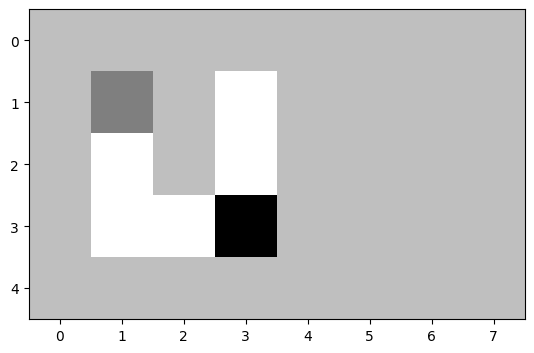

States: 144, Actions: 4, Observations 32, Thetas [(1, 1), (2, 1)]



In [18]:
# maze size
N = 2

# thetas deformations (range(a,b),range(c,d))
l0 = 1
h0 = 3
l1 = 1
h1 = 2

maze = np.load(f"maze/maze_{N}.npy")
env = GridEnvDeform(maze,l0,h0,l1,h1)
env.render()

states = [((x,y,phi),(i,j)) for x in range(1,env.max_shape[0]-1) for y in range(1,env.max_shape[1]-1) for phi in range(4) for i in range(l0,h0) for j in range(l1,h1)] 
actions = [0,1,2,3]
obs = list(itertools.product([0,1], repeat=5))
thetas = [(i,j) for i in range(l0,h0) for j in range(l1,h1)]

state_dict = {state: i for i, state in enumerate(states)}
obs_dict = {obs : i for i, obs in enumerate(obs)}

# Actions are: 0-listen, 1-open-left, 2-open-right
lenS = len(states)
lenA = len(actions)
lenO = len(obs)

print(f"States: {lenS}, Actions: {lenA}, Observations {lenO}, Thetas {thetas}\n")


In [19]:
env_wrapper = POMDPWrapper_v1(env, T,O,R)

# infotaxis

Initial state:  ((3, 4, 3), (2, 1))


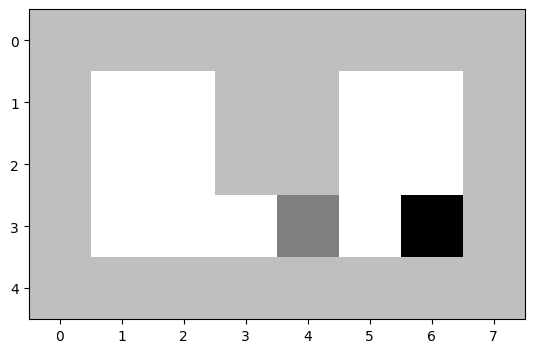

Best action:  0
state 127


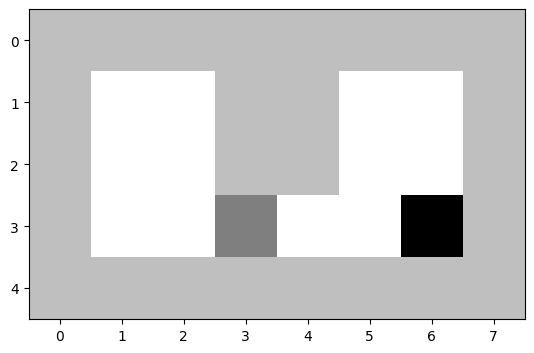

Step:  9
Timestep missing: 9  
Total reward:     -0.5  
Chosen action:  0
Actual State:  ((3, 3, 3), (2, 1))
argmax and max Belief:  ((1, 2, 1), (1, 1)) tensor(0.1667)
Belief entropy:  2.5849623680114746
Best action:  1
state 119


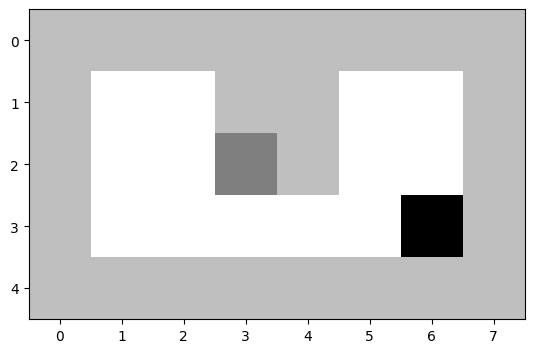

Step:  8
Timestep missing: 8  
Total reward:     -2.5  
Chosen action:  1
Actual State:  ((2, 3, 0), (2, 1))
argmax and max Belief:  ((2, 3, 0), (2, 1)) tensor(0.5000)
Belief entropy:  1.0
Best action:  1
state 65


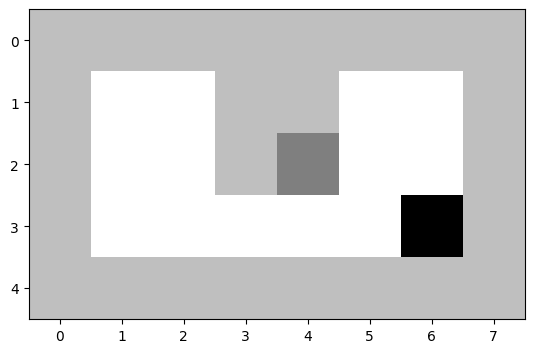

Step:  7
Timestep missing: 7  
Total reward:     -4.5  
Chosen action:  1
Actual State:  ((2, 4, 1), (2, 1))
argmax and max Belief:  ((2, 4, 1), (2, 1)) tensor(1.)
Belief entropy:  -0.0
Best action:  0
state 75


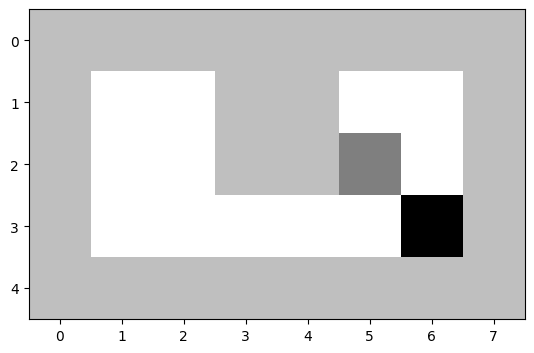

Step:  6
Timestep missing: 6  
Total reward:     -5.0  
Chosen action:  0
Actual State:  ((2, 5, 1), (2, 1))
argmax and max Belief:  ((2, 5, 1), (2, 1)) tensor(1.)
Belief entropy:  -0.0
Best action:  0
state 83


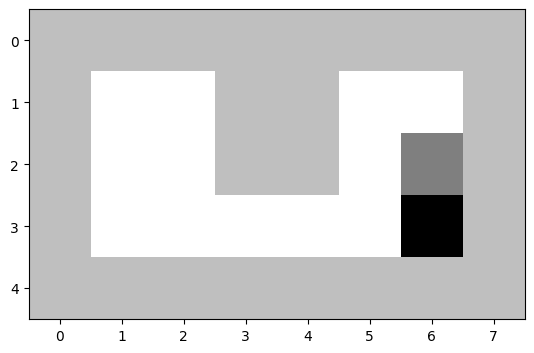

Step:  5
Timestep missing: 5  
Total reward:     -5.5  
Chosen action:  0
Actual State:  ((2, 6, 1), (2, 1))
argmax and max Belief:  ((2, 6, 1), (2, 1)) tensor(1.)
Belief entropy:  -0.0
Best action:  0
state 91


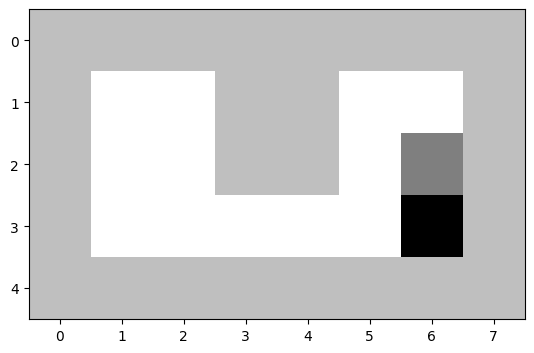

Step:  4
Timestep missing: 4  
Total reward:     -6.5  
Chosen action:  0
Actual State:  ((2, 6, 1), (2, 1))
argmax and max Belief:  ((2, 6, 1), (2, 1)) tensor(1.)
Belief entropy:  -0.0
Best action:  0
state 91


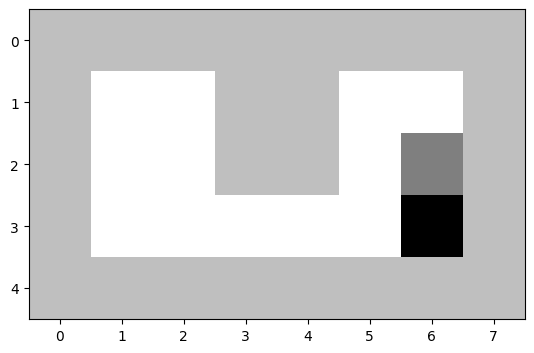

Step:  3
Timestep missing: 3  
Total reward:     -7.5  
Chosen action:  0
Actual State:  ((2, 6, 1), (2, 1))
argmax and max Belief:  ((2, 6, 1), (2, 1)) tensor(1.)
Belief entropy:  -0.0
Best action:  0
state 91


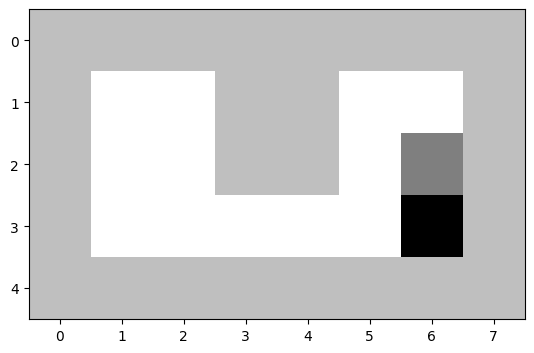

Step:  2
Timestep missing: 2  
Total reward:     -8.5  
Chosen action:  0
Actual State:  ((2, 6, 1), (2, 1))
argmax and max Belief:  ((2, 6, 1), (2, 1)) tensor(1.)
Belief entropy:  -0.0
Best action:  0
state 91


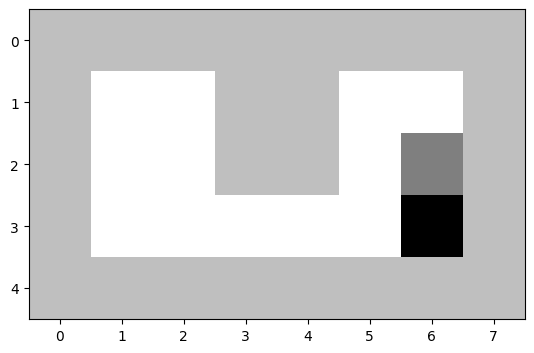

Step:  1
Timestep missing: 1  
Total reward:     -9.5  
Chosen action:  0
Actual State:  ((2, 6, 1), (2, 1))
argmax and max Belief:  ((2, 6, 1), (2, 1)) tensor(1.)
Belief entropy:  -0.0
Best action:  0
state 91


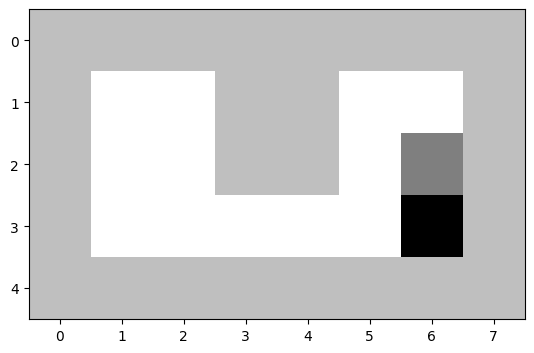

Step:  0
Timestep missing: 0  
Total reward:     -10.5  
Chosen action:  0
Actual State:  ((2, 6, 1), (2, 1))
argmax and max Belief:  ((2, 6, 1), (2, 1)) tensor(1.)
Belief entropy:  -0.0


In [5]:
# the simulation starts with given belief and random state
b = torch.ones(len(states)) / len(states)
s = np.random.randint(len(states))

print("Initial state: ", states[s])
env.render(states[s])

horizon = 10
totalReward = 0.0

for t in range(horizon - 1, -1, -1):

    best_action = Infotaxis.get_action(b)

    #best_action = np.random.choice([0,1,2,3])
    print("Best action: ", best_action)
    print("state", s)
    next_obs, reward, done, info = env_wrapper.step(s, best_action)
    
    next_state = info['actual_state']
    env.render(states[next_state])



    totalReward += reward
    next_belief = Infotaxis.update_belief(b, best_action, next_obs)
    
    print("Step: ", t)
    print("Timestep missing: " + str(t) + "  ") # Print space after to clear
    print("Total reward:     " + str(totalReward) + "  ")
    print("Chosen action: ", best_action)

    print("Actual State: ", states[next_state])
    print("argmax and max Belief: ", states[torch.argmax(next_belief)], torch.max(next_belief))
    print("Belief entropy: ", Infotaxis.get_entropy(next_belief))

    if t == 1:
        assert states[torch.argmax(next_belief)] == states[next_state] 
    
    # Then we update the world
    s = next_state
    b = next_belief
    # Sleep 1 second so the user can see what is happening.
    time.sleep(1)



In [8]:
b = torch.rand(10)
print(b)
torch.exp(b)

tensor([0.3686, 0.7249, 0.5607, 0.8371, 0.8711, 0.7325, 0.8298, 0.5433, 0.8754,
        0.2942])


tensor([1.4457, 2.0644, 1.7518, 2.3096, 2.3895, 2.0803, 2.2929, 1.7216, 2.3998,
        1.3420])

# space aware infotaxis

l'idea è usare coome misura di costo il MDP per lo shortest path

## shortest path MDP

dovrebbe lavorare con full observability \
dovrebbe essere impedito l'attraversamento dei muri ? 

In [68]:
class GridEnvDeform_ssp():
    def __init__(self, maze, l0,h0,l1,h1):

        self.original_maze = maze
        self.original_maze_shape = maze.shape
 
        self.maze = maze
        self.maze_shape = maze.shape

        # list of possible actions
        self.actions = [0,1,2,3]
        # list of possible orientations
        self.orientations = [0,1,2,3]
        # list of possible observations
        self.obs = list(itertools.product([0,1], repeat=5))
        # list of possible deformations
        self.deformations = [(i,j) for i in range(l0,h0) for j in range(l1,h1)]
        
        # space in which every maze lives (is a 2d matrix)
        self.max_shape = self.original_maze.shape * np.array([h1-1,h0-1]) + np.array([2,2])
        # list of states
        self.states = [((x,y,phi),(i,j)) for x in range(1,self.max_shape[0]-1) for y in range(1,self.max_shape[1]-1) for phi in range(4) for i in range(l0,h0) for j in range(l1,h1)] 
        self.l0 = l0
        self.h0 = h0
        self.l1 = l1
        self.h1 = h1

        self.goal_pos = self.original_maze.shape - np.array([2,2])
        
        self.reset()
        
    def step(self, a, s=None, execute=False):

        """take action a from state s (if given) or from actual state of the maze 
        
        return the next state, the reward, if the episode is terminated, if the episode is truncated, info"""
        
        if s is not None:
            self.set_state(s)
            x, y, phi = s[0][:3]
            x_, y_, phi_ = x, y, phi
        else:
            x, y = self.agent_pos
            phi = self.agent_orientation
            x_, y_, phi_ = x, y, phi

        actual_action = (a + phi) % 4
        
        if actual_action == 0:  # Move up
            new_pos = [x - 1, y]
        elif actual_action == 2:  # Move down
            new_pos = [x + 1, y]
        elif actual_action == 3:  # Move left
            new_pos = [x, y - 1]
        elif actual_action == 1:  # Move right
            new_pos = [x, y + 1]
        else:
            raise ValueError("Invalid Action")
        
        # Check if the new position is valid (inside the maze and not a wall)
        if 0 < new_pos[0] < self.max_shape[0]-1 and 0 < new_pos[1] < self.max_shape[1]-1:
            x_, y_ = new_pos
            if execute:
                self.agent_pos = new_pos

        phi_ = (phi + a) % 4
        
        if execute:
            self.agent_orientation = phi_
        
        terminated = np.all((x_,y_) == self.goal_pos)

        if np.all((x_,y_) == self.goal_pos):
            # if the agent is in the goal position
            reward =  0            
        elif np.all((x_,y_) == (x,y)):
            # if the agent has not moved (only at the boundary of the maze)
            reward =  -100 # -50/(self.max_shape[0]*self.max_shape[1])
        elif self.maze[x_, y_] == 1:
            # if the agent has entered a wall
            reward =  -100 # -50/(self.max_shape[0]*self.max_shape[1])
        elif self.maze[x_, y_] == 0:
            # if the agent has moved to a free cell
            reward =  -1 # -1/(self.max_shape[0]*self.max_shape[1])

        info = {}
        truncated = False 

        s_ = ((x_, y_, phi_), self.theta)
        
        if execute:
            self.timestep += 1
        
        return s_, reward, terminated, truncated, info, 
    
    def get_observation(self, s=None):

        if s is None:
            agent_pos = self.agent_pos
            agent_orientation = self.agent_orientation
        else: 
            self.set_deformed_maze(s[1])
            agent_pos = s[0][:2]
            agent_orientation = s[0][2]

        ind = [agent_pos + a for a in [np.array([0,-1]),
                                            np.array([-1,-1]),
                                            np.array([-1,0]),
                                            np.array([-1,+1]),
                                            np.array([0,+1]),
                                            np.array([+1,+1]),
                                            np.array([+1,0]),
                                            np.array([+1,-1])]]

        agent_obs = np.array([self.maze[tuple(ind[i%8])] 
                                                for i in range(2*agent_orientation, 2*agent_orientation+5)])

        
        return agent_obs
    
    def set_deformed_maze(self,thetas: tuple):
        self.theta = thetas
        self.maze = self.stretch_maze(thetas)
        # self.goal_pos = self.maze.shape - np.array([thetas[1],thetas[0]])
        self.goal_pos = self.original_maze.shape * np.array([thetas[1],thetas[0]])

        canva1 = np.ones(self.max_shape, dtype=int)  # Start with walls
        # Place the original maze in the canvas
        canva1[1:self.maze.shape[0] + 1, 1:self.maze.shape[1] + 1] = self.maze

        self.maze = canva1
   
    def stretch_maze(self, thetas):
        scale_x, scale_y = thetas
        maze = self.original_maze

        original_height, original_width = maze.shape
        # Calculate new dimensions
        new_height = original_height * scale_y
        new_width = original_width * scale_x
        
        # Create a new maze with stretched dimensions
        stretched_maze = np.ones((new_height, new_width), dtype=int)

        # Fill the new maze with values from the original maze
        for i in range(original_height):
            for j in range(original_width):
                if maze[i, j] == 0:  # Path cell
                    # Fill the corresponding region in the stretched maze
                    stretched_maze[i*scale_y:(i+1)*scale_y, j*scale_x:(j+1)*scale_x] = 0

        return stretched_maze
    
    def set_state(self, s):
        theta0, theta1 = s[1][0], s[1][1]
        self.theta = (theta0, theta1)
        self.agent_pos = np.array(s[0][:2]) 
        self.agent_orientation = s[0][2]
        self.set_deformed_maze(s[1])
    
    def get_state(self):
        return (self.agent_pos[0],self.agent_pos[1], self.agent_orientation), self.theta
    
    def render(self, s=None, s_prime=None):
        """
        belief will be always distributed as follows 
        there exist a tuple (x_0,y_0,phi_0) such that
        for the two possible deformations theta0 theta1

        b((x_0,y_0,phi_0), theta_0) = b((x_0,y_0,phi_0), theta_1) = 0.5
        and 
        b = 0 everywere else
        
        rendering will show the same position in the two different possibile maze deformations
        along with the probability of each status
        """
        if s is not None:
            self.set_state(s)
        
        maze_render = np.copy(self.maze)
        maze_render[tuple(self.agent_pos)] = 2  # Show agent position
        maze_render[tuple(self.goal_pos)] = 4  # Show goal position
        plt.imshow(maze_render, cmap='binary', origin='upper')
        plt.show()

    def reset(self, seed=42):
        randomdeformation = random.choice(self.deformations)
        self.agent_pos = [np.random.randint(1, self.max_shape[0]-1), np.random.randint(1, self.max_shape[1]-1)]
        self.agent_orientation = random.choice(self.orientations)
        self.set_deformed_maze(randomdeformation)
        self.goal_pos = self.original_maze.shape * np.array([randomdeformation[1],randomdeformation[0]])
        self.theta = randomdeformation
        self.timestep = 0
        return ((self.agent_pos[0],self.agent_pos[1], self.agent_orientation), self.theta), {}
        
    def is_done(self):
        return np.all(self.agent_pos == self.goal_pos)
    
    def is_new(self):
        return self.timestep == 0



In [69]:
env = GridEnvDeform_ssp(maze,l0,h0,l1,h1)

In [70]:
from agents.tabular_qlearning import q_learning

Q = q_learning(env, 10000, 0.1, 1, 0.5, states_dict=state_dict)

np.save(f"agents/tabularQ_maze_{N}.npy", Q)

# Q = np.load(f"agents/tabularQ_maze_{N}.npy")    

Episode 1/10000, Average Reward: -798.1268011527377
Episode 101/10000, Average Reward: -995.8104793756968
Episode 201/10000, Average Reward: -755.1358024691358
Episode 301/10000, Average Reward: -917.632299270073
Episode 401/10000, Average Reward: -1308.069532237674
Episode 501/10000, Average Reward: -1163.9969418960245
Episode 601/10000, Average Reward: -1231.510989010989
Episode 701/10000, Average Reward: -496.3775038520801
Episode 801/10000, Average Reward: -1003.617166212534
Episode 901/10000, Average Reward: -613.2139130434782
Episode 1001/10000, Average Reward: -700.6717865804366
Episode 1101/10000, Average Reward: -752.2511520737327
Episode 1201/10000, Average Reward: -581.8968481375358
Episode 1301/10000, Average Reward: -891.5151515151515
Episode 1401/10000, Average Reward: -1055.304394426581
Episode 1501/10000, Average Reward: -871.9253438113949
Episode 1601/10000, Average Reward: -719.1857868020304
Episode 1701/10000, Average Reward: -948.1517436380773
Episode 1801/10000, Av

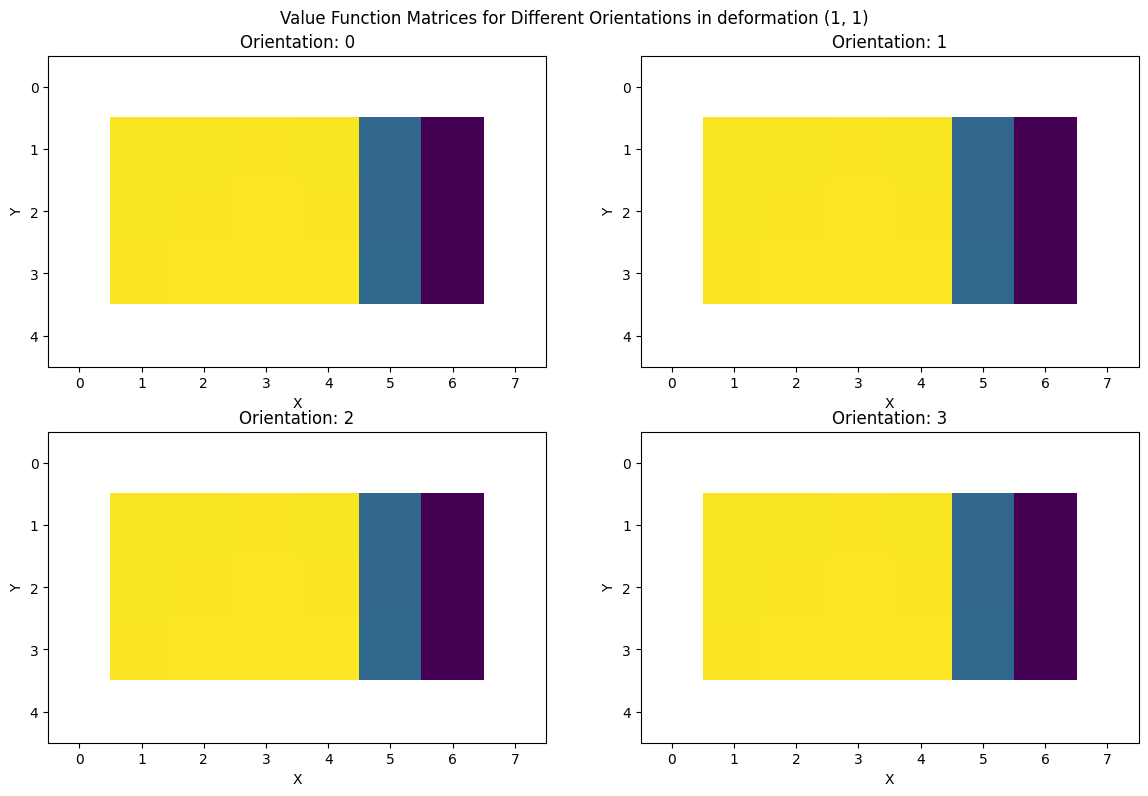

In [71]:
state_value = np.max(Q,axis=1)


# fix orientation and deformation
deformation = (1, 1)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for orientation in range(4):
    Value_matrix_plot = np.zeros(env.maze.shape) - np.inf
    for s, state in enumerate(states):
        if state[1] == deformation and state[0][2] == orientation:
            Value_matrix_plot[state[0][0], state[0][1]] = state_value[s]
    
    ax = axes[orientation]
    ax.imshow(Value_matrix_plot, )
    ax.set_title(f"Orientation: {orientation}")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")

plt.suptitle(f"Value Function Matrices for Different Orientations in deformation {deformation}")
plt.tight_layout()
plt.show()

In [72]:
print(torch.tensor(Value_matrix_plot))

tensor([[     -inf,      -inf,      -inf,      -inf,      -inf,      -inf,
              -inf,      -inf],
        [     -inf,   -1.7500,   -1.5000,   -1.0000,   -1.5000, -100.7500,
         -150.3750,      -inf],
        [     -inf,   -1.5000,   -1.0000,    0.0000,   -1.0000, -100.5000,
         -150.2500,      -inf],
        [     -inf,   -1.0000,    0.0000,    0.0000,    0.0000, -100.0000,
         -150.0000,      -inf],
        [     -inf,      -inf,      -inf,      -inf,      -inf,      -inf,
              -inf,      -inf]], dtype=torch.float64)


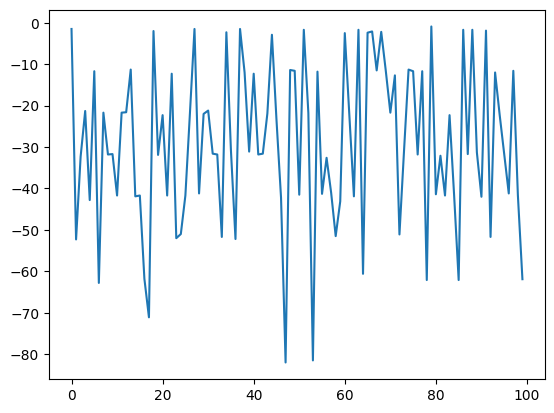

In [73]:
def eval_tabular(env : GridEnvDeform, Q, num_episodes=100, max_episode_steps=25, render=False):
    total_rewards = []

    for episode in range(num_episodes):
        s, _ = env.reset()
        state = state_dict[s]

        episode_reward = 0
        done = False
        c = max_episode_steps
        while not done and c > 0:
            if render:
                env.render()

            # Agent takes an action using a greedy policy (without exploration)
            action = np.argmax(Q[state])
            if render:
                print(f"State: {s}, Action: {action}")
            next_state, reward, done, _, info = env.step(action.item(), s, execute=render)
            state = state_dict[next_state]
            s = next_state

            episode_reward += reward
            
            if done or c == 1:
                total_rewards.append(episode_reward)
                # print(f"Episode {episode + 1}/{num_episodes}, Reward: {episode_reward}")

            c -= 1
    avg_reward = np.mean(total_rewards)
    # print(f"Average Reward over {num_episodes} episodes: {avg_reward}")
    return avg_reward

rewards = [eval_tabular(env, Q, 10) for _ in range(100)]  
plt.plot(rewards)

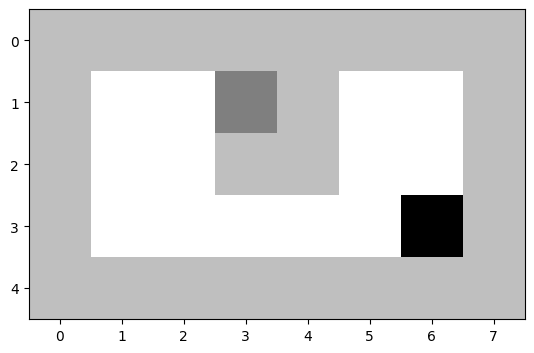

State: ((1, 3, 0), (2, 1)), Action: 3


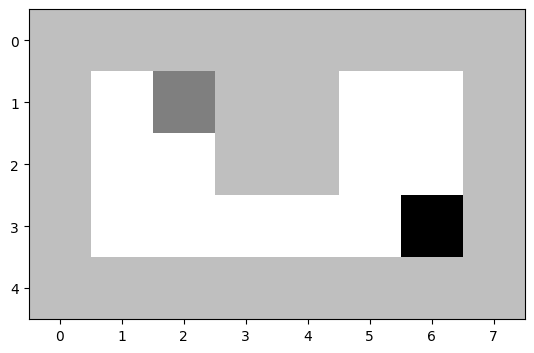

State: ((1, 2, 3), (2, 1)), Action: 3


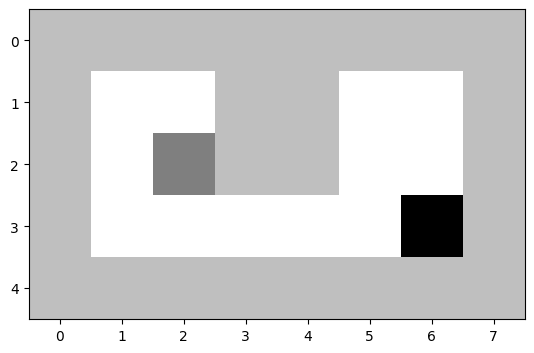

State: ((2, 2, 2), (2, 1)), Action: 0


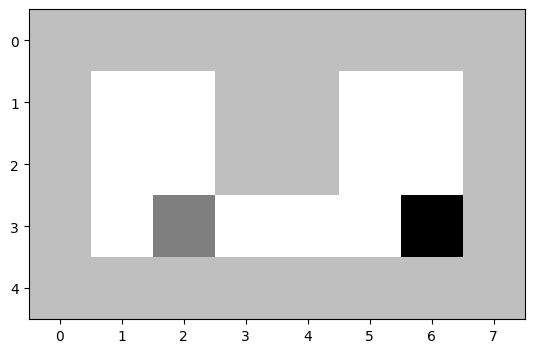

State: ((3, 2, 2), (2, 1)), Action: 3


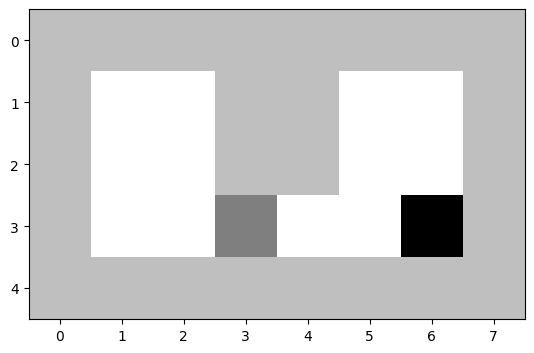

State: ((3, 3, 1), (2, 1)), Action: 0


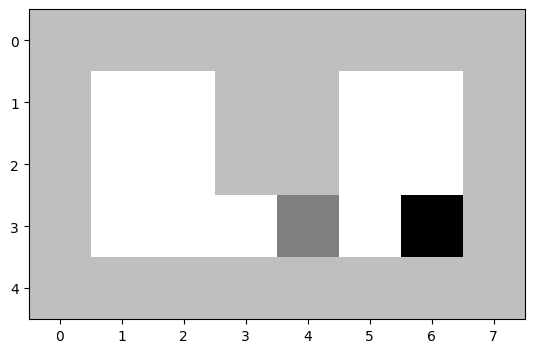

State: ((3, 4, 1), (2, 1)), Action: 0


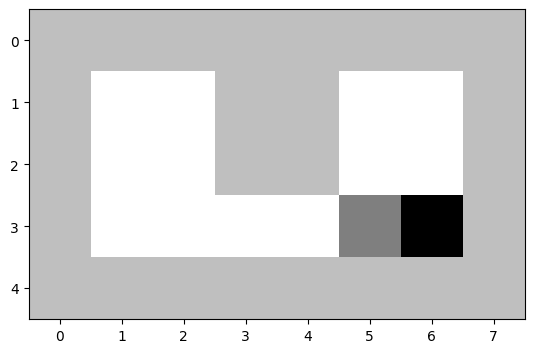

State: ((3, 5, 1), (2, 1)), Action: 0


np.float64(-6.0)

In [74]:
eval_tabular(env, Q, 1, max_episode_steps=10, render=True)

In [104]:
distance = np.zeros(len(states))
for s, state in enumerate(states):
    env.set_state(state)
    ss = s
    totalReward = 0
    steps = 0
    while not env.is_done() and steps < 100:
        action = np.argmax(Q[ss])
        next_state, reward, done, _, info = env.step(action, execute=True)
        ss = state_dict[next_state]
        totalReward += reward
        steps += 1
    distance[s] = totalReward

In [108]:
state = ((1, 2, 0), (1, 1))
distance[state_dict[state]]

np.float64(-2.0)

In [109]:
distance

array([  -3.,   -6.,   -3.,   -6.,   -3.,   -6.,   -3.,   -6.,   -2.,
         -5.,   -2.,   -5.,   -2.,   -5.,   -2.,   -5.,   -1.,   -6.,
         -1.,   -6.,   -1.,   -6.,   -1.,   -6.,   -2.,   -3.,   -2.,
         -3.,   -2.,   -3.,   -2.,   -3., -102.,   -2., -102.,   -2.,
       -102.,   -2., -102.,   -2., -202.,   -1., -202.,   -1., -202.,
         -1., -202.,   -1.,   -2.,   -5.,   -2.,   -5.,   -2.,   -5.,
         -2.,   -5.,   -1.,   -4.,   -1.,   -4.,   -1.,   -4.,   -1.,
         -4.,    0.,   -3.,    0.,   -3.,    0.,   -3.,    0.,   -3.,
         -1.,   -2.,   -1.,   -2.,   -1.,   -2.,   -1.,   -2., -101.,
         -1., -101.,   -1., -101.,   -1., -101.,   -1., -201.,    0.,
       -201.,    0., -201.,    0., -201.,    0.,   -1.,   -4.,   -1.,
         -4.,   -1.,   -4.,   -1.,   -4.,    0.,   -3.,    0.,   -3.,
          0.,   -3.,    0.,   -3.,    0.,   -2.,    0.,   -2.,    0.,
         -2.,    0.,   -2.,    0.,   -1.,    0.,   -1.,    0.,   -1.,
          0.,   -1.,

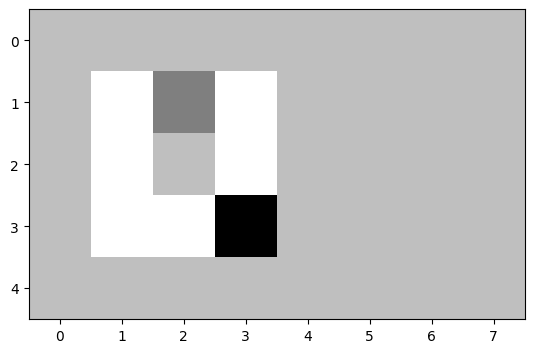

In [107]:
env.render(state)